# Exploring SACLA data files

## Preliminary operations
There is a bunch of modules and utilities to be loaded. Besides the usual ones (numpy, matplotlib, etc), there are also some custom made tools. 

All the required modules can be obtained loading `load_defaults.py` (works only in ipython!)

In [16]:
# needed only to get interactive plots in notebook
%matplotlib nbagg
import os
os.chdir("../")

In [17]:
# %load load_defaults.py
"""
Created on Tue Oct 20 15:40:48 2015

@author: sala
"""

import os

PWD = os.getcwd()
TOOLS_DIR = PWD + "/../"

import numpy as np
print "Imported NumPy as np"

import matplotlib.pyplot as plt
plt.style.use('ggplot')
print "Imported Matplotlib.pyplot as plt, with ggplot style"

import h5py
print "Imported h5py"

import sys

# Loading SACLA tools 
SACLA_LIB = PWD
sys.path.append(SACLA_LIB)
import utilities as sacla_utils
print "Imported sacla_utils"

# Loading ImagesProcessor
try:
    from photon_tools.images_processor import ImagesProcessor
    from photon_tools.plot_utilities import plot_utilities as pu
    import photon_tools.hdf5_utilities as h5u
    print "Imported ImagesProcessor"
    print "Imported plot_utilities as pu"
    print "Imported hdf5_utilities as h5u"
except:
    try:
        sys.path.append(TOOLS_DIR)
        from photon_tools.images_processor import ImagesProcessor
        from photon_tools.plot_utilities import plot_utilities as pu
        import photon_tools.hdf5_utilities as h5u
        print "Imported ImagesProcessor"
        print "Imported plot_utilities as pu"
        print "Imported hdf5_utilities as h5u"
    except:
        print "[ERROR] cannot load ImagesProcessor library"


Imported NumPy as np
Imported Matplotlib.pyplot as plt, with ggplot style
Imported h5py
Imported sacla_utils
Imported ImagesProcessor
Imported plot_utilities as pu
Imported hdf5_utilities as h5u


Also, there are some quantities that makes sense to define. These can be loaded from `default_daq_names.py`

In [18]:
# %load ../default_daq_names.py
"""
Created on Tue Oct 20 16:13:41 2015

@author: sala
"""

# Define SACLA quantities - they can change from beamtime to beamtime
daq_labels = {}
daq_labels["I0_down"] = "event_info/bl_3/eh_4/photodiode/photodiode_I0_lower_user_7_in_volt"
daq_labels["I0_up"] = "event_info/bl_3/eh_4/photodiode/photodiode_I0_upper_user_8_in_volt"
daq_labels["TFY"] = "event_info/bl_3/eh_4/photodiode/photodiode_sample_PD_user_9_in_volt"
daq_labels["photon_mono_energy"] = "event_info/bl_3/tc/mono_1_position_theta"
daq_labels["delay"] = "event_info/bl_3/eh_4/laser/delay_line_motor_29"
daq_labels["ND"] = "event_info/bl_3/eh_4/laser/nd_filter_motor_26"
daq_labels["photon_sase_energy"] = "event_info/bl_3/oh_2/photon_energy_in_eV"
daq_labels["x_status"] = "event_info/bl_3/eh_1/xfel_pulse_selector_status"
daq_labels["x_shut"] = "event_info/bl_3/shutter_1_open_valid_status"
daq_labels["laser_status"] = "event_info/bl_3/lh_1/laser_pulse_selector_status"
daq_labels["tags"] = "event_info/tag_number_list"

## Exploring HDF5

HDF5 structure can be complex: because of that, there are some custom tools for exploring and searching.

Let's start defining the data directory, and listing it:

In [19]:
os.chdir("notebooks")
DIR = "/home/sala/Work/Data/SACLA/"

!ls $DIR

256745.h5      257723_roi.h5  258929_roi.h5  dark_256635.h5
257722_roi.h5  258878_roi.h5  259408_roi.h5


and let's print the first level of the tree:

In [20]:
run = "257722"
fname = DIR + run + "_roi.h5"

h5u.print_leaf(fname, level=1)

/file_info/format_type
/file_info/run_number_list
/file_info/version
/run_257722/detector_2d_1
/run_257722/detector_2d_2
/run_257722/event_info
/run_257722/exp_info
/run_257722/run_info


We can also search for a string inside the file:

In [21]:
h5u.search_hdf5(fname, "photon")

run_257722/event_info/bl_3/oh_2/photon_energy_in_eV
run_257722/run_info/sacla_config/photon_energy_in_eV


{u'run_257722/event_info/bl_3/oh_2/photon_energy_in_eV': {'dtype': dtype('float32'),
  'shape': (500,)},
 u'run_257722/run_info/sacla_config/photon_energy_in_eV': {'dtype': dtype('float64'),
  'shape': ()}}

## Getting and plotting DAQ data

SACLA HDF5 files contain also data from the DAQ system, mainly motor positions, point detectors. The datasets name within the file are for examples the ones encoded in `daq_names`. Some of these quantities are stored in fancy units, like motor steps and so on. So, a set of converters are provided in the `sacla_utils` module, to help translating these funny units in e.g. pump-probe delay. *WARNING* most of these translations are beamtime defined.

In [8]:
help(sacla_utils.beamtime_converter_201411XX)


Help on module utilities.beamtime_converter_201411XX in utilities:

NAME
    utilities.beamtime_converter_201411XX

FILE
    /home/sala/Work/GIT/swissfel-photonics/sacla/utilities/beamtime_converter_201411XX.py

FUNCTIONS
    convert(name, array, **kwargs)
    
    dataset_name(name)
    
    get_delay_from_pulse(pulse, t0=0)
        Translate delay pulses (motor steps) into ps
    
    get_energy_from_theta(theta_position)
        Translate the monochromator theta position in keV
    
    get_generic(value)

DATA
    NAN = nan




In [9]:
f = h5py.File(fname)
delays = f["/run_" + run + "/" + daq_labels["delay"]][:10]
print delays
print sacla_utils.beamtime_converter_201411XX.convert("delay", delays)

[32925 32925 32925 32925 32925 32925 32925 32925 32925 32925]
[ 219.51529937  219.51529937  219.51529937  219.51529937  219.51529937
  219.51529937  219.51529937  219.51529937  219.51529937  219.51529937]


There is a tool for loading scalar data from the file, and put it into a Pandas `DataFrame`:

In [10]:
df, fnames = sacla_utils.analysis.get_data_daq(fname, daq_labels, sacla_utils.beamtime_converter_201411XX)
df.head()


Selection efficiency
        Eff.  Selected  Total
run                          
257722     1       500    500

Events per run and delay settings
run     delay  photon_mono_energy
257722  219.5  9.67                  500
Name: I0, dtype: int64


,I0_down,I0_up,ND,TFY,delay,laser_status,photon_mono_energy,photon_sase_energy,photon_sase_energy_mean,run,x_shut,x_status,I0,is_laser
tags,,,,,,,,,,,,,,
407715060,0.775361,0.625844,0,0.320009,219.5,0,9.67,NaN,9660.068359,257722,1,1,1.401205,False
407715062,0.118713,0.096584,0,0.049153,219.5,1,9.67,NaN,9660.068359,257722,1,1,0.215297,True
407715064,0.000000,0.000000,0,0.570095,219.5,0,9.67,NaN,9660.068359,257722,1,1,0.000000,False
407715066,0.359732,0.289155,0,0.148587,219.5,1,9.67,NaN,9660.068359,257722,1,1,0.648887,True
407715068,0.092887,0.074835,0,0.038384,219.5,0,9.67,NaN,9660.068359,257722,1,1,0.167723,False


We can also add selections:

In [11]:
sel = "x_status == 1 & x_shut == 1"
df, fnames = sacla_utils.analysis.get_data_daq(fname, daq_labels, sacla_utils.beamtime_converter_201411XX, selection=sel)


Selection efficiency
        Eff.  Selected  Total
run                          
257722     1       500    500

Events per run and delay settings
run     delay  photon_mono_energy
257722  219.5  9.67                  500
Name: I0, dtype: int64


Now, a bit of fun: let's plot!

<IPython.core.display.Javascript object>


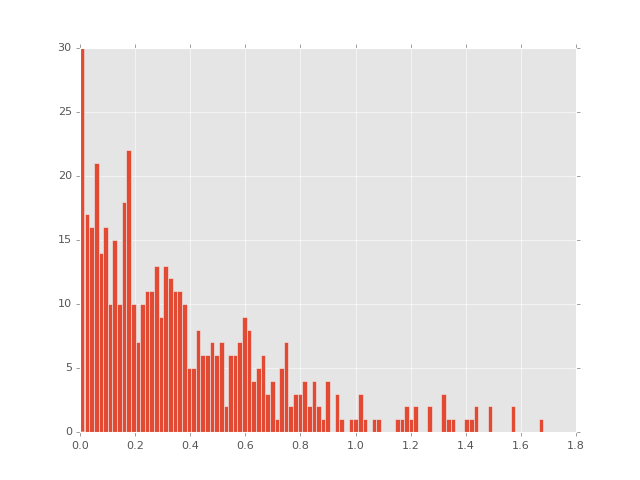

<IPython.core.display.Javascript object>


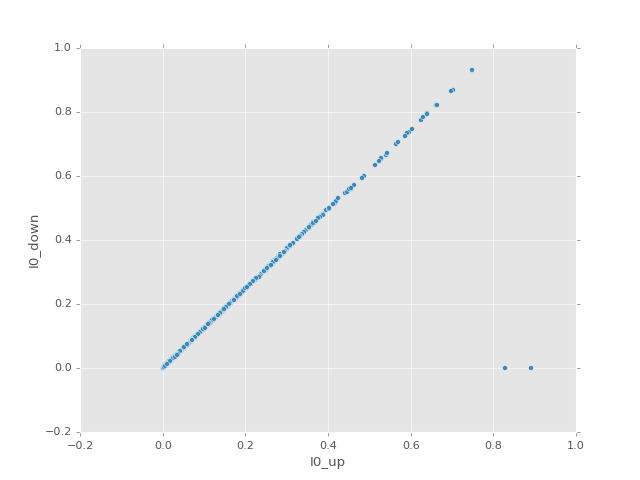

<IPython.core.display.Javascript object>


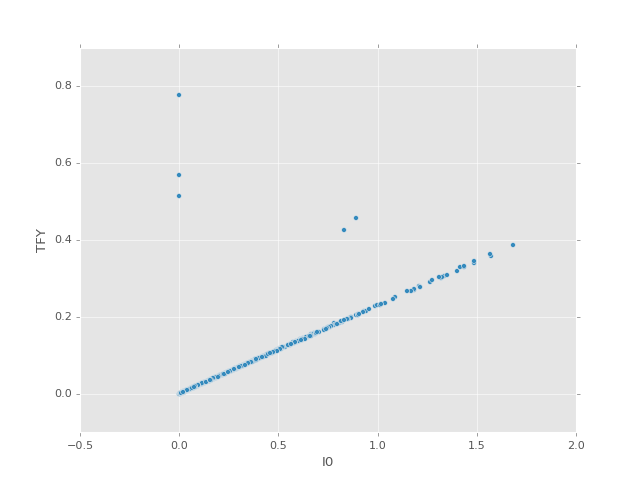

In [12]:
df["I0"].hist(bins=100)
df.plot(x="I0_up", y="I0_down", kind="scatter")
df.plot(x="I0", y="TFY", kind="scatter")
plt.show()

We can also use good old plain matplotlib:

<IPython.core.display.Javascript object>


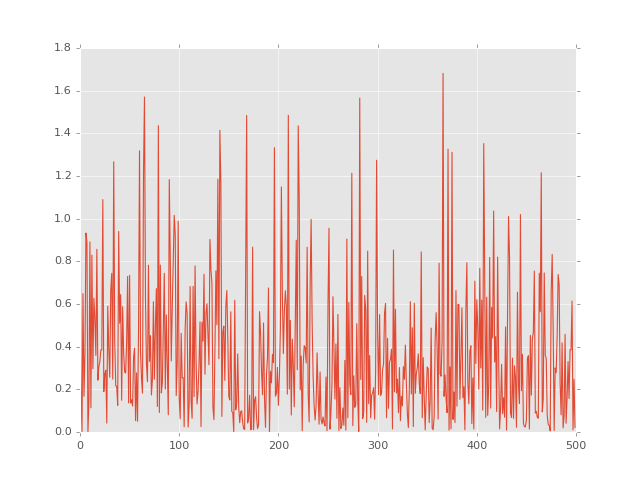

In [13]:
plt.figure()
plt.plot(df["I0"])
plt.show()

We can load more files, and do statistics on the dataframe:

In [14]:
files = [DIR + f for f in os.listdir(DIR) if f.find("roi") != -1]

sel = "x_status == 1 & x_shut == 1 & I0_up>0.01 & I0_down > 0.01"
df_tot, fnames_tot = sacla_utils.analysis.get_data_daq(files, daq_labels, sacla_utils.beamtime_converter_201411XX, selection=sel)


Selection efficiency
            Eff.  Selected  Total
run                              
257722  0.924000       462    500
257723  0.914000       457    500
258878  0.988519      5338   5400
258929  0.988000      4940   5000
259408  0.987500      1975   2000

Events per run and delay settings
run     delay  photon_mono_energy
257722  219.5  9.670                  462
257723  220.0  9.670                  457
258878  225.9  9.658                 5338
258929  230.9  9.655                 4940
259408  222.4  9.667                 1975
Name: I0, dtype: int64


In [15]:
print "Average and Standard error per Run"
print df_tot.groupby("run")["I0"].mean()
print df_tot.groupby("run")["I0"].sem()

print "\nAverage per Run and laser status"
print df_tot.groupby(["photon_mono_energy", "is_laser"])["TFY"].mean()



Average and Standard error per Run
run
257722    0.398669
257723    0.376308
258878    0.526063
258929    0.493734
259408    0.506773
Name: I0, dtype: float64
run
257722    0.015310
257723    0.015002
258878    0.004235
258929    0.004276
259408    0.006710
Name: I0, dtype: float64

Average per Run and laser status
photon_mono_energy  is_laser
9.655               False       0.004901
                    True        0.004845
9.658               False       0.007048
                    True        0.007266
9.667               False       0.077588
                    True        0.078682
9.670               False       0.090179
                    True        0.087733
Name: TFY, dtype: float64


## Images analysis

Analysis images is a bit more tricky... images are bigger, and in SACLA data files are stored in a funny way. There is a custom tool, provided by `ImagesProcessor`, which helps dealing with it. Let's start creating an object:

In [16]:
ip = ImagesProcessor(facility="SACLA")

`ImagesProcessor` loops over images, and applies `preprocess` and `analysis` functions, which can be easily loaded. Let's see what's available, and let's load them:

In [17]:
print ip.available_preprocess
print ip.available_analyses
help(ip.available_analyses["get_projection"][0])

{'set_roi': <function set_roi at 0x7f11846808c0>, 'subtract_correction': <function subtract_correction at 0x7f11846809b0>, 'set_thr': <function set_thr at 0x7f1184680938>, 'correct_bad_pixels': <function correct_bad_pixels at 0x7f1184680aa0>}
{'get_projection': (<function get_projection at 0x7f11846806e0>, None), 'get_mean_std': (<function get_mean_std at 0x7f1184680758>, <function get_mean_std_results at 0x7f11846807d0>), 'get_histo_counts': (<function get_histo_counts at 0x7f1184680848>, None)}
Help on function get_projection in module tools.images_processor.image_analyses:

get_projection(results, temp, image_in, axis=0, thr_hi=None, thr_low=None)
    Returns a spectra (projection) over an axis of an image. This function is to be used within an AnalysisProcessor instance.
    
    Parameters
    ----------
    results : dict
        dictionary containing the results. This is provided by the AnalysisProcessor class
    temp : dict
        dictionary containing temporary variables. Th

In [18]:
ip.add_preprocess('set_thr', args={"thr_low": 65})
ip.add_analysis("get_mean_std")

[INFO] Preprocess set_thr added


Then, you can add a dataset to be analyzed, and run the analysis:

In [19]:
ip.set_dataset("run_%s/detector_2d_1" % run, remove_preprocess=False)
results = ip.analyze_images(fnames[0], n=-1)
print results.keys()

['get_mean_std', 'tags']


We get a results dictionary, indexed with the name of the analysis performed. Let's plot the average image, using `plotting_utilities`:

<IPython.core.display.Javascript object>


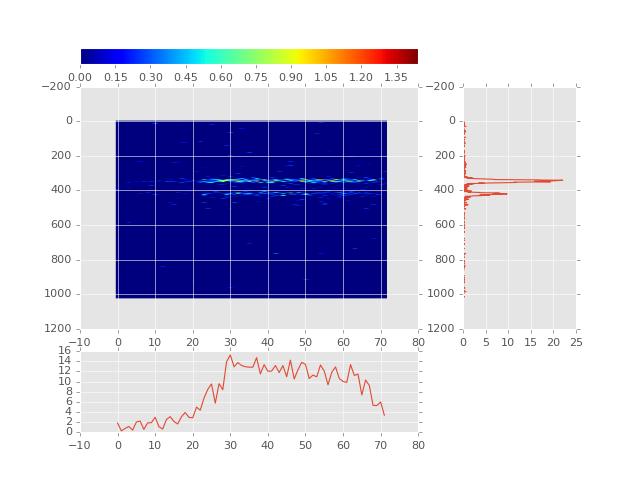

In [20]:
pu.plot_image_and_proj(results["get_mean_std"]["images_mean"])

We can also run over some selected tags... for example, we used some selections when getting DAQ data: let's get now the tags for that selection:

<IPython.core.display.Javascript object>


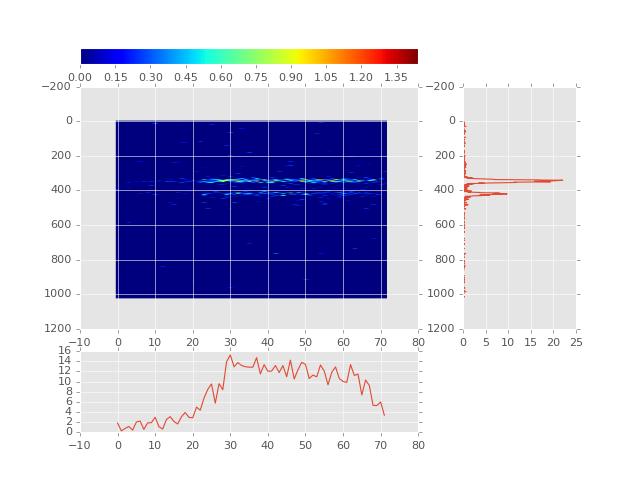

In [21]:
tags_sel = df.index.tolist()

results_sel = ip.analyze_images(fnames[0], n=-1, tags=tags_sel)
pu.plot_image_and_proj(results["get_mean_std"]["images_mean"])

Together with the available analysis `get_projection`, this can be quite useful to produce *pump-probe* spectra:

<IPython.core.display.Javascript object>


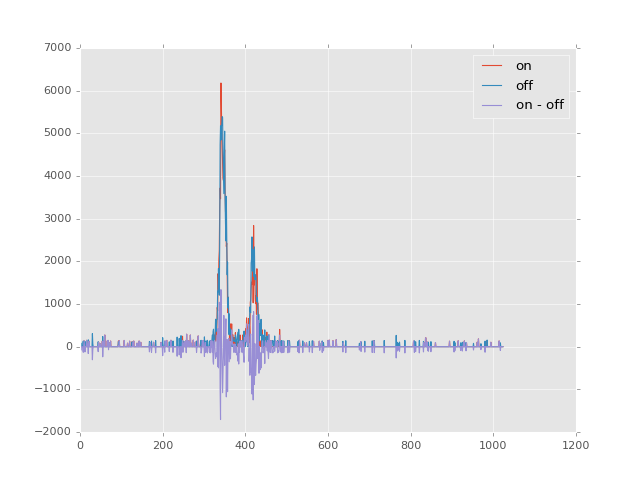

In [22]:
tags_on = df[df["is_laser"] == 1].index.tolist()
tags_off = df[df["is_laser"] == 0].index.tolist()

ip.add_analysis("get_projection", args={"axis": 1})

results_on = ip.analyze_images(fnames[0], n=-1, tags=tags_on)
results_off = ip.analyze_images(fnames[0], n=-1, tags=tags_off)

on = results_on["get_projection"]["spectra"].sum(axis=0)
off = results_off["get_projection"]["spectra"].sum(axis=0)

plt.figure()
plt.plot(on, label="on")
plt.plot(off, label="off")
plt.plot(on - off, label="on - off")
plt.legend(loc="best")
plt.show()

`get_projection` returns a spectra per event: that's why we do the sum then. But then we can create a simple function that does this for us, and passing it to the `ImagesProcessor`:

<IPython.core.display.Javascript object>


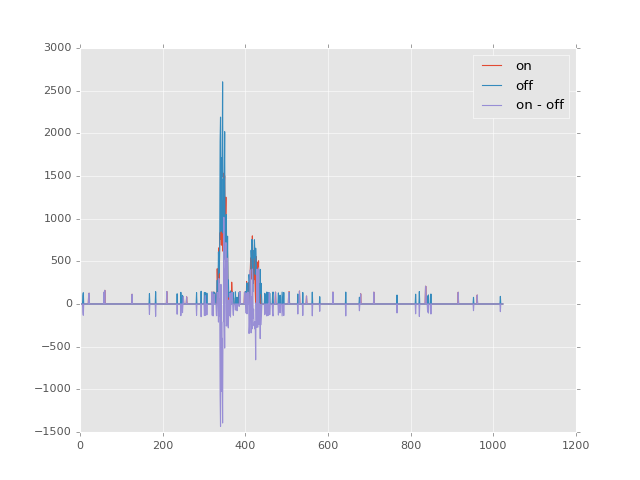

In [23]:
def get_total_projection(results, temp, image_in, ):
    # if there is no image, return NaN
    if image_in is None:
        result = np.ones(temp["image_shape"][0], dtype=temp["image_dtype"])
        result[:] = np.NAN
    else:
        result = np.nansum(image_in, axis=1)

    if results.has_key("spectra") is False:
        results["spectra"] = result
    else:
        results["spectra"] = np.add(results["spectra"], result)
    temp["current_entry"] += 1
    return results, temp

ip.remove_analysis("get_projection")
ip.add_analysis(get_total_projection, label="get_total_projection")

results_on = ip.analyze_images(fnames[0], n=100, tags=tags_on)
results_off = ip.analyze_images(fnames[0], n=100, tags=tags_off)

on = results_on["get_total_projection"]["spectra"]
off = results_off["get_total_projection"]["spectra"]

plt.figure()
plt.plot(on, label="on")
plt.plot(off, label="off")
plt.plot(on - off, label="on - off")
plt.legend(loc="best")
plt.show()

or, easier, if we want the sum of the counts for every image:

<IPython.core.display.Javascript object>


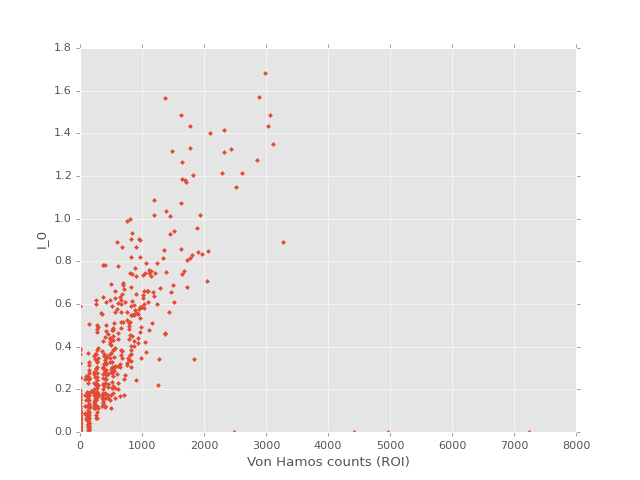

In [24]:
def get_total_counts(results, temp, image_in, ):
    # if there is no image, return NaN
    if temp["current_entry"] == 0:
        results["counts"] = np.empty((results['n_entries'], ), dtype=np.int64) 
    
    if image_in is None:
        results["counts"][temp["current_entry"]] = 0
    else:
        results["counts"][temp["current_entry"]] = image_in.sum()
    temp["current_entry"] += 1
    return results, temp

ip.remove_analysis("get_total_projection")
ip.add_analysis(get_total_counts, label="get_total_counts")

results = ip.analyze_images(fnames[0], n=-1, tags=df.index.tolist())

counts = results["get_total_counts"]["counts"]

plt.figure()
plt.plot(counts, df["I0"], ".")
plt.xlabel("Von Hamos counts (ROI)")
plt.ylabel("I_0")
plt.show()